In [2]:
import pandas as pd
import os
import openpyxl
import pickle
import re
import nltk
import copy
import warnings
import gensim
import matplotlib.pyplot as plt
import pyLDAvis

from nltk.corpus import stopwords
from tqdm import tqdm
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
from gensim.models import CoherenceModel

In [3]:
df = pd.read_csv('amazon_WAN282X1GB.csv')

In [4]:
df

,Unnamed: 0,Dates,Ratings,Titles,Bodys
0,0,2023-04-30,4,Stunning!!!,Video Player is loading.Play VideoPlayMuteCurr...
1,1,2023-04-17,4,Short hoses,Machine is good but water inlet hose and drain...
2,2,2023-04-17,5,that it was as good as my previous bosh washin...,brill
3,3,2023-01-22,4,Would recommend buying this.,This is the most expensive washing machine I’v...
4,4,2023-03-30,5,Excellent Product.,"Very good Machine ,price is excellent & very e..."
...,...,...,...,...,...
295,295,2021-02-28,5,So quiet!,Upgraded from my 5 year old Bosch and glad I d...
296,296,2021-06-26,5,"So, so quiet",I had to look to make sure the washing machine...
297,297,2021-02-16,5,Good washer,Does the job A+++
298,298,2021-10-13,4,IT LOOKS GREAT BUT NO INSTALLATION PROVIDED,"It seems to be as advertised, but what was ver..."


In [5]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
df.columns = ['Date', 'Star', 'Title', 'Body']

In [7]:
df

,Date,Star,Title,Body
0,2023-04-30,4,Stunning!!!,Video Player is loading.Play VideoPlayMuteCurr...
1,2023-04-17,4,Short hoses,Machine is good but water inlet hose and drain...
2,2023-04-17,5,that it was as good as my previous bosh washin...,brill
3,2023-01-22,4,Would recommend buying this.,This is the most expensive washing machine I’v...
4,2023-03-30,5,Excellent Product.,"Very good Machine ,price is excellent & very e..."
...,...,...,...,...
295,2021-02-28,5,So quiet!,Upgraded from my 5 year old Bosch and glad I d...
296,2021-06-26,5,"So, so quiet",I had to look to make sure the washing machine...
297,2021-02-16,5,Good washer,Does the job A+++
298,2021-10-13,4,IT LOOKS GREAT BUT NO INSTALLATION PROVIDED,"It seems to be as advertised, but what was ver..."


In [8]:
df['clean_text'] = pd.Series(dtype='object')
df['stopwords_after'] = pd.Series(dtype='object')
df['pos_tag'] = pd.Series(dtype='object')
df['NN'] = pd.Series(dtype='object')
df['lemmatization'] = pd.Series(dtype='object')

In [9]:
stops = stopwords.words('english')
stops.append('machine')
stops.append('product')
stops.append('bosch')

In [10]:
df

,Date,Star,Title,Body,clean_text,stopwords_after,pos_tag,NN,lemmatization
0,2023-04-30,4,Stunning!!!,Video Player is loading.Play VideoPlayMuteCurr...,NaN,NaN,NaN,NaN,NaN
1,2023-04-17,4,Short hoses,Machine is good but water inlet hose and drain...,NaN,NaN,NaN,NaN,NaN
2,2023-04-17,5,that it was as good as my previous bosh washin...,brill,NaN,NaN,NaN,NaN,NaN
3,2023-01-22,4,Would recommend buying this.,This is the most expensive washing machine I’v...,NaN,NaN,NaN,NaN,NaN
4,2023-03-30,5,Excellent Product.,"Very good Machine ,price is excellent & very e...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
295,2021-02-28,5,So quiet!,Upgraded from my 5 year old Bosch and glad I d...,NaN,NaN,NaN,NaN,NaN
296,2021-06-26,5,"So, so quiet",I had to look to make sure the washing machine...,NaN,NaN,NaN,NaN,NaN
297,2021-02-16,5,Good washer,Does the job A+++,NaN,NaN,NaN,NaN,NaN
298,2021-10-13,4,IT LOOKS GREAT BUT NO INSTALLATION PROVIDED,"It seems to be as advertised, but what was ver...",NaN,NaN,NaN,NaN,NaN


In [11]:
def clean_text(texts): 
    corpus = []
    
    for i in tqdm(range(0, len(texts))):
        
        body = texts[i]
        
        body = re.sub('[^a-zA-Z]', ' ', body) # 특수문자 제거 
        body = body.lower().split() # 대문자를 소문자로 변경, 문장을 단어 단위로 구분
        
        df['clean_text'][i] = body
        
        no_stops = [word for word in body if not word in stops] # 불용어 제거
        df['stopwords_after'][i] = no_stops
        
        tokens_pos = nltk.pos_tag(df['stopwords_after'][i]) # pos tagging (품사 태깅)
        df['pos_tag'][i] = tokens_pos
        
        NN_words = [] # 명사만 추출
        for word, pos in tokens_pos:
            if 'NN' in pos:
                NN_words.append(word)
                df['NN'][i] = NN_words
                
        wlem = nltk.WordNetLemmatizer() # Lemmatization(원형(lemma) 찾기) # nltk에서 제공되는 WordNetLemmatizer을 이용
        lemmatized_words = []
        for word in NN_words:
            new_word = wlem.lemmatize(word)
            lemmatized_words.append(new_word)
            df['lemmatization'][i] = lemmatized_words
        
        corpus.append(no_stops) 
        
    return corpus

In [12]:
clean_text(df['Body'])

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatization'][i] = lemmatized_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatization'][i] = lemmatized_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatizatio

  0%|▎                                                                                 | 1/300 [00:01<05:55,  1.19s/it]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

  4%|██▉                                                                              | 11/300 [00:01<00:25, 11.29it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

  7%|█████▉                                                                           | 22/300 [00:01<00:11, 24.07it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

 14%|███████████                                                                      | 41/300 [00:01<00:05, 49.88it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

 19%|███████████████                                                                  | 56/300 [00:01<00:03, 67.55it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_tag'][i] = tokens_pos
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Lo

 23%|██████████████████▋                                                              | 69/300 [00:01<00:02, 78.11it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_tag'][i] = tokens_pos
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Lo

 36%|████████████████████████████▋                                                  | 109/300 [00:01<00:01, 126.10it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

 44%|██████████████████████████████████▊                                            | 132/300 [00:02<00:01, 151.94it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

 52%|█████████████████████████████████████████▎                                     | 157/300 [00:02<00:00, 176.42it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

 62%|████████████████████████████████████████████████▋                              | 185/300 [00:02<00:00, 203.80it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_tag'][i] = tokens_pos
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Lo

 85%|███████████████████████████████████████████████████████████████████▍           | 256/300 [00:02<00:00, 267.55it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Tem

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_tag'][i] = tokens_pos
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Lo

 95%|███████████████████████████████████████████████████████████████████████████    | 285/300 [00:02<00:00, 232.94it/s]C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = body
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_after'][i] = no_stops
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Temp\ipykernel_13316\3025838010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NN'][i] = NN_words
C:\Users\HOME\AppData\Local\Tem

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 112.20it/s]


[['video',
  'player',
  'loading',
  'play',
  'videoplaymutecurrent',
  'time',
  'duration',
  'loaded',
  'stream',
  'type',
  'liveseek',
  'live',
  'currently',
  'behind',
  'liveliveremaining',
  'time',
  'xplayback',
  'ratechapterschaptersdescriptionsdescriptions',
  'selectedcaptionscaptions',
  'selectedaudio',
  'trackfullscreenthis',
  'modal',
  'window',
  'purchased',
  'kg',
  'silver',
  'inox',
  'washing',
  'match',
  'haier',
  'silver',
  'inox',
  'fridge',
  'freezer',
  'nice',
  'quiet',
  'speed',
  'perfect',
  'setting',
  'halves',
  'time',
  'setting',
  'choose',
  'make',
  'sure',
  'remove',
  'keep',
  'four',
  'bolts',
  'washer',
  'ensure',
  'smooth',
  'wash',
  'spin',
  'pleasure',
  'ears',
  'rocking',
  'rolling',
  'also',
  'noticed',
  'wash',
  'results',
  'better',
  'items',
  'even',
  'look',
  'cleaner',
  'paid',
  'installed',
  'unfortunately',
  'leak',
  'noticed',
  'time',
  'guys',
  'come',
  'back',
  'rectify',
 

In [13]:
df

,Date,Star,Title,Body,clean_text,stopwords_after,pos_tag,NN,lemmatization
0,2023-04-30,4,Stunning!!!,Video Player is loading.Play VideoPlayMuteCurr...,"[video, player, is, loading, play, videoplaymu...","[video, player, loading, play, videoplaymutecu...","[(video, NN), (player, NN), (loading, VBG), (p...","[video, player, time, duration, stream, type, ...","[video, player, time, duration, stream, type, ..."
1,2023-04-17,4,Short hoses,Machine is good but water inlet hose and drain...,"[machine, is, good, but, water, inlet, hose, a...","[good, water, inlet, hose, drain, hose, short,...","[(good, JJ), (water, NN), (inlet, NN), (hose, ...","[water, inlet, hose, drain, appliance, sink, w...","[water, inlet, hose, drain, appliance, sink, w..."
2,2023-04-17,5,that it was as good as my previous bosh washin...,brill,[brill],[brill],"[(brill, NN)]",[brill],[brill]
3,2023-01-22,4,Would recommend buying this.,This is the most expensive washing machine I’v...,"[this, is, the, most, expensive, washing, mach...","[expensive, washing, owned, honestly, say, fir...","[(expensive, JJ), (washing, NN), (owned, VBN),...","[washing, clothes, cycle, modes, ones, fact, a...","[washing, clothes, cycle, mode, one, fact, add..."
4,2023-03-30,5,Excellent Product.,"Very good Machine ,price is excellent & very e...","[very, good, machine, price, is, excellent, ve...","[good, price, excellent, easy, install, would,...","[(good, JJ), (price, NN), (excellent, NN), (ea...","[price, excellent, install, others]","[price, excellent, install, others]"
...,...,...,...,...,...,...,...,...,...
295,2021-02-28,5,So quiet!,Upgraded from my 5 year old Bosch and glad I d...,"[upgraded, from, my, year, old, bosch, and, gl...","[upgraded, year, old, glad, awesome, washing, ...","[(upgraded, JJ), (year, NN), (old, JJ), (glad,...","[year, washing, mode, clothes]","[year, washing, mode, clothes]"
296,2021-06-26,5,"So, so quiet",I had to look to make sure the washing machine...,"[i, had, to, look, to, make, sure, the, washin...","[look, make, sure, washing, working, quiet, cl...","[(look, NNS), (make, VBP), (sure, JJ), (washin...","[look, clothes, time, delivery, persons, job, ...","[look, clothes, time, delivery, person, job, r..."
297,2021-02-16,5,Good washer,Does the job A+++,"[does, the, job, a]",[job],"[(job, NN)]",[job],[job]
298,2021-10-13,4,IT LOOKS GREAT BUT NO INSTALLATION PROVIDED,"It seems to be as advertised, but what was ver...","[it, seems, to, be, as, advertised, but, what,...","[seems, advertised, disappointing, installatio...","[(seems, VBZ), (advertised, JJ), (disappointin...","[installation, option, pay, call, pay, money, ...","[installation, option, pay, call, pay, money, ..."


In [14]:
df.dropna(inplace = True, axis = 0) # 결측치 제거

In [15]:
df.reset_index(inplace = True) # 인덱스 초기화

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            281 non-null    int64 
 1   Date             281 non-null    object
 2   Star             281 non-null    int64 
 3   Title            281 non-null    object
 4   Body             281 non-null    object
 5   clean_text       281 non-null    object
 6   stopwords_after  281 non-null    object
 7   pos_tag          281 non-null    object
 8   NN               281 non-null    object
 9   lemmatization    281 non-null    object
dtypes: int64(2), object(8)
memory usage: 22.1+ KB


In [17]:
df_cp = copy.deepcopy(df) # 데이터 복사본 생성

*길이가 2이하인 문자 확인*

In [18]:
count = 0
for idx1, st1 in enumerate(df_cp['lemmatization']):
    for idx2, st2 in enumerate(st1):
        if len(st2) <= 2:
            print(f"character : {st2}, df_cp['lemmatization'][{idx1}][{idx2}]")
            count += 1
        else:
            continue
print("=" * 50); print(f"총 {count}개")

character : x, df_cp['lemmatization'][7][20]
character : ok, df_cp['lemmatization'][15][11]
character : kg, df_cp['lemmatization'][37][0]
character : kg, df_cp['lemmatization'][37][9]
character : kg, df_cp['lemmatization'][39][14]
character : yr, df_cp['lemmatization'][42][9]
character : tv, df_cp['lemmatization'][51][4]
character : ad, df_cp['lemmatization'][51][5]
character : yr, df_cp['lemmatization'][51][14]
character : us, df_cp['lemmatization'][55][15]
character : kg, df_cp['lemmatization'][58][12]
character : mm, df_cp['lemmatization'][75][3]
character : kg, df_cp['lemmatization'][98][4]
character : w, df_cp['lemmatization'][101][0]
character : w, df_cp['lemmatization'][101][11]
character : ok, df_cp['lemmatization'][110][0]
character : mm, df_cp['lemmatization'][127][3]
character : e, df_cp['lemmatization'][135][4]
character : gb, df_cp['lemmatization'][150][0]
character : im, df_cp['lemmatization'][182][0]
character : kg, df_cp['lemmatization'][234][3]
character : kg, df_cp['l

*길이가 2이하인 문자 제거*

In [21]:
count = 0
for idx1, st1 in enumerate(df_cp['lemmatization']):
    for idx2, st2 in enumerate(st1):
        if len(st2) <= 2:
            print(f'제거된 문자 : {st2}')
            del df_cp['lemmatization'][idx1][idx2]
            count += 1
        else:
            continue
print("=" * 40); print(f'제거된 문자는 총 {count}개 입니다.')

제거된 문자 : ad
제거된 문자는 총 1개 입니다.


*제거되었는지 검증* → *if 제거되지 않은 문자가 존재할 경우 바로 위 코드를 다시 수행*

In [22]:
count = 0
for idx1, st1 in enumerate(df_cp['lemmatization']):
    for idx2, st2 in enumerate(st1):
        if len(st2) <= 2:
            print(f'제거되지 않은 문자가 있습니다. : {st2}')
            count += 1
        else:
            continue

if count != 0:
    print(f'{count}개 문자 제거 요망')
else:
    print('길이가 2이하인 문자는 존재하지 않습니다.')

길이가 2이하인 문자는 존재하지 않습니다.


In [23]:
dictionary = corpora.Dictionary(df_cp['lemmatization'])
corpus = [dictionary.doc2bow(text) for text in df_cp['lemmatization']]

In [24]:
df_cp['lemmatization']

0      [video, player, time, duration, stream, type, ...
1      [water, inlet, hose, drain, appliance, sink, w...
2                                                [brill]
3      [washing, clothes, cycle, mode, one, fact, add...
4                    [price, excellent, install, others]
                             ...                        
276                       [year, washing, mode, clothes]
277    [look, clothes, time, delivery, person, job, r...
278                                                [job]
279    [installation, option, pay, call, pay, money, ...
280                                               [wash]
Name: lemmatization, Length: 281, dtype: object

최적의 토픽 수 선정을 위해 Coherence score 확인
- 토픽이 얼마나 의미론적으로 일관성이 있는지를 판단함
- 높을수록 의미론적 일관성이 높음
- 모델이 얼마나 의미있는 결과를 도출하는지 확인

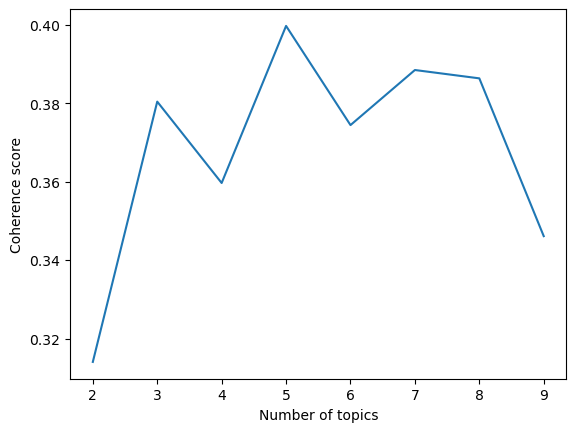

In [25]:
coherence_value = []
texts = [i for i in df_cp['lemmatization']] # Coherence score visualization을 위해 List comprehension 수행

for i in range(2, 10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = texts, dictionary = dictionary, topn = 10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_value.append(coherence_lda)
    
x = range(2, 10)
plt.plot(x, coherence_value)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.show()

In [26]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 7, id2word = dictionary, passes = 20)
topics = ldamodel.print_topics(num_words = 10)

for i in topics:
    print(i)

(0, '0.042*"use" + 0.035*"job" + 0.019*"cycle" + 0.016*"excellent" + 0.014*"program" + 0.013*"load" + 0.012*"installation" + 0.012*"wife" + 0.011*"spin" + 0.011*"thing"')
(1, '0.034*"washer" + 0.031*"spin" + 0.020*"use" + 0.019*"clothes" + 0.019*"love" + 0.017*"delivery" + 0.016*"service" + 0.015*"item" + 0.015*"cycle" + 0.014*"time"')
(2, '0.046*"wash" + 0.032*"time" + 0.024*"year" + 0.021*"spin" + 0.020*"clothes" + 0.016*"programme" + 0.016*"option" + 0.014*"cycle" + 0.012*"washing" + 0.012*"thing"')
(3, '0.039*"wash" + 0.029*"program" + 0.028*"day" + 0.028*"quality" + 0.025*"cycle" + 0.021*"time" + 0.015*"year" + 0.012*"water" + 0.010*"pipe" + 0.010*"delivery"')
(4, '0.045*"value" + 0.040*"money" + 0.024*"time" + 0.021*"wash" + 0.019*"delivery" + 0.017*"cycle" + 0.017*"washing" + 0.016*"clothes" + 0.016*"installation" + 0.015*"speed"')
(5, '0.103*"use" + 0.041*"cycle" + 0.028*"install" + 0.025*"clothes" + 0.020*"delivery" + 0.019*"programme" + 0.017*"clean" + 0.017*"program" + 0.014

In [27]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)